In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import sys
import seaborn as sns

from tqdm import tqdm

import librosa
import librosa.display

import IPython.display as ipd  # возможность что то выводить в юпитер (видео, звук...)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import  keras
from keras import layers
from keras.models import Sequential
from keras.utils import to_categorical

In [2]:
data_path = fr'C:\ML\DataBases\audios'

## Тест обработки звука на одном примере

`выбираем случайный файл из датасета`

In [3]:
while True:
    folder = np.random.choice(os.listdir(data_path))  # берем случайный файл из общего датасета
    if not os.path.isfile(folder):  # про5веряемЯ, не выбрали ли мы случайно метедату
        random_audio_path = fr'{data_path}\{folder}\{np.random.choice(os.listdir(data_path + "/" + folder))}'
        break
random_audio_path

'C:\\ML\\DataBases\\audios\\fold8\\7065-6-0-0.wav'

In [4]:
audio_data, sampling_rate = librosa.load(random_audio_path)
# audio_data - аудио файл, преобразованный в числа
# sampling_rate - частота дискретизации

ipd.Audio(random_audio_path)

## Амплитуда звукового сигнала

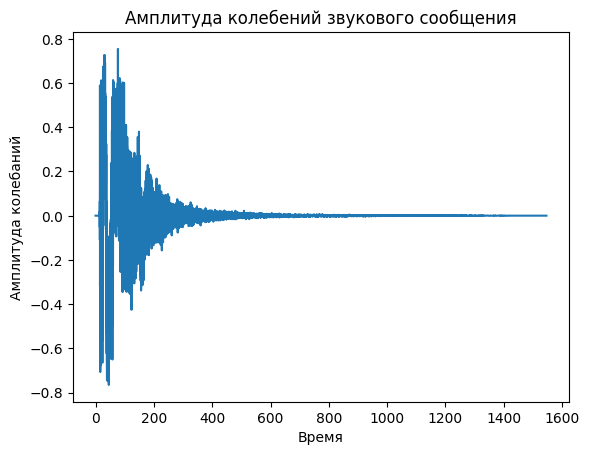

In [5]:
# продолжительность звукового файла
duration = len(audio_data) / sampling_rate

# создание массива времени проигрывания файла
time = librosa.times_like(audio_data, sr=sampling_rate)

plt.plot(time, audio_data)
plt.title('Амплитуда колебений звукового сообщения')
plt.xlabel('Время')
plt.ylabel('Амплитуда колебаний');

`тот же график в логарифмическом масштабе`

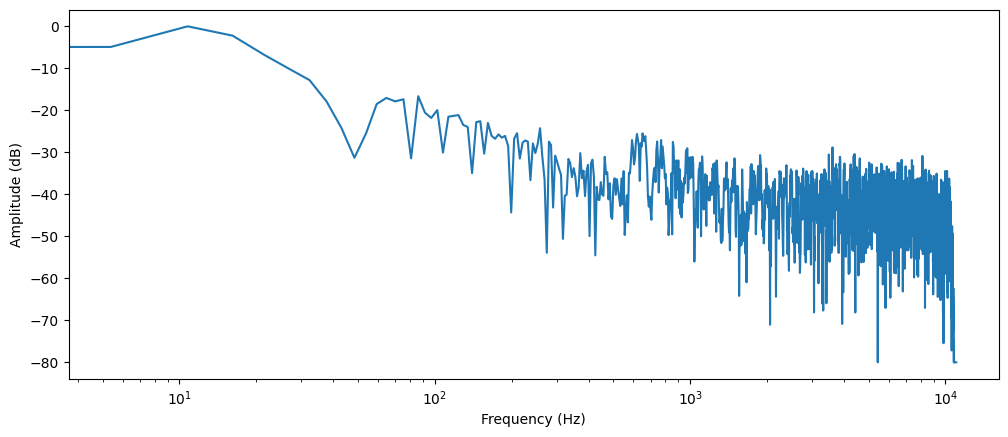

In [6]:
dft_input = audio_data[:4096]

# Рассчитаем ДПФ
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# получим амплитудный спектр в децибелах
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# получим частотные столбцы
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

## Спектрограмма

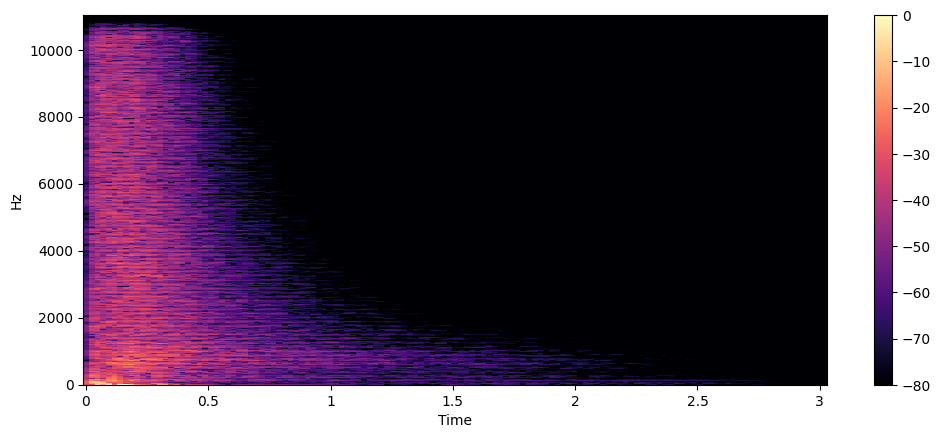

In [7]:
D = librosa.stft(audio_data)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show();

## Метадата

In [8]:
metadata = pd.read_csv(fr'C:\ML\DataBases\audios\urban_sounds.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [9]:
metadata['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [10]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

## Обработка данных

`преобразование звука в тензор данных с нормализацией`

In [11]:
# нормализация методом малочастотных коэффициентов
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
# n_mfcc - количество коэффициентов MFCC

mfccs

array([[-189.86386  ,  -25.712393 ,   13.288505 , ..., -507.07755  ,
        -507.07755  , -507.07755  ],
       [  65.23471  ,   60.80598  ,   53.093933 , ...,    0.       ,
           0.       ,    0.       ],
       [  24.261503 ,   26.992762 ,   27.638445 , ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [  -4.623583 ,   -8.981195 ,   -7.2672467, ...,    0.       ,
           0.       ,    0.       ],
       [  -8.9383745,  -12.230254 ,  -10.224066 , ...,    0.       ,
           0.       ,    0.       ],
       [  -7.7694883,   -7.0613155,    0.7417842, ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)

In [12]:
mfccs.shape

(40, 131)

In [13]:
# функция для обработки звука

def feature_extractor(file_name):
    audio_data, sampling_rate = librosa.load(file_name)
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
    scaled_mfcc_features = np.mean(mfcc_features.T, axis=0)
    return scaled_mfcc_features

In [14]:
# обработка звуковых файлов

extracted_features = []
for i, row in tqdm(metadata.iterrows()):  # типо .itmes для словаря
    # i - номер строки
    # row - данные с этой строки
    fold = 'fold' + str(row["fold"]) + '\\'
    file = row['slice_file_name']
    file_path = os.path.join(data_path, fold, file)

    data = feature_extractor(file_path)
    label = row['class']
    extracted_features.append([data, label])

3551it [00:21, 171.36it/s]c:\Python\python_3.11.8\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8322it [00:48, 213.03it/s]c:\Python\python_3.11.8\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Python\python_3.11.8\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [00:50, 173.84it/s]


In [15]:
extracted_features = pd.DataFrame(extracted_features, columns=['data', 'class'])
extracted_features

,data,class
0,"[-211.93698, 62.581207, -122.81315, -60.74528,...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.19586, ...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.81649, -...",car_horn
8730,"[-336.92386, 115.313896, -44.8471, 24.968985, ...",car_horn


## Разделение данных

In [16]:
x = np.array(extracted_features['data'].to_list())
y = np.array(extracted_features['class'].to_list())

In [17]:
x.shape

(8732, 40)

`перевод лейблов с помощью энкодера`

In [18]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [20]:
num_labels = y.shape[1]
num_labels

10

## Создание модели

In [21]:
model = Sequential()

model.add(layers.Input(shape=(40,)))

# первый слой
model.add(layers.Dense(100))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# второй слой
model.add(layers.Dense(200))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# третий слой
model.add(layers.Dense(100))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# финальный слой
model.add(layers.Dense(num_labels))
model.add(layers.Activation('softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # используется если классы пересекаются между собой
              metrics=['accuracy', 'mae', 'mse']
              )

In [24]:
epochs = 200
batch_size = 32

callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.008, verbose=0)

In [25]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200




219/219 [==============================] - 1s 2ms/step - loss: 11.1729 - accuracy: 0.1204 - mae: 0.1766 - mse: 0.1340 - val_loss: 2.2933 - val_accuracy: 0.1110 - val_mae: 0.1798 - val_mse: 0.0898
Epoch 2/200
219/219 [==============================] - 0s 1ms/step - loss: 2.6305 - accuracy: 0.1171 - mae: 0.1783 - mse: 0.0948 - val_loss: 2.2814 - val_accuracy: 0.1128 - val_mae: 0.1795 - val_mse: 0.0896
Epoch 3/200
219/219 [==============================] - 0s 1ms/step - loss: 2.3561 - accuracy: 0.1105 - mae: 0.1788 - mse: 0.0908 - val_loss: 2.2729 - val_accuracy: 0.1133 - val_mae: 0.1793 - val_mse: 0.0895
Epoch 4/200
219/219 [==============================] - 0s 1ms/step - loss: 2.2911 - accuracy: 0.1266 - mae: 0.1784 - mse: 0.0896 - val_loss: 2.2672 - val_accuracy: 0.1151 - val_mae: 0.1791 - val_mse: 0.0894
Epoch 5/200
219/219 [==============================] - 0s 1ms/step - loss: 2.2706 - accuracy: 0.1251 - mae: 0.1780 - mse: 0.0892 - val_loss: 2.2573 - val_accuracy: 0.1202 - val_mae: 

## Проверка метрик

In [26]:
test_metrics = model.evaluate(x_test, y_test)
test_metrics = zip(test_metrics, ['loss', 'accuracy', 'mae', 'mse'])
for num, metric in test_metrics:
    print(f'{metric}: {num}')

 1/55 [..............................] - ETA: 0s - loss: 0.8380 - accuracy: 0.7500 - mae: 0.0854 - mse: 0.0373

55/55 [==============================] - 0s 644us/step - loss: 0.7978 - accuracy: 0.7459 - mae: 0.0808 - mse: 0.0355
loss: 0.7977690696716309
accuracy: 0.7458500266075134
mae: 0.08083266019821167
mse: 0.0354737751185894


## Визуализация метрик при обучении,

In [27]:
def full_plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

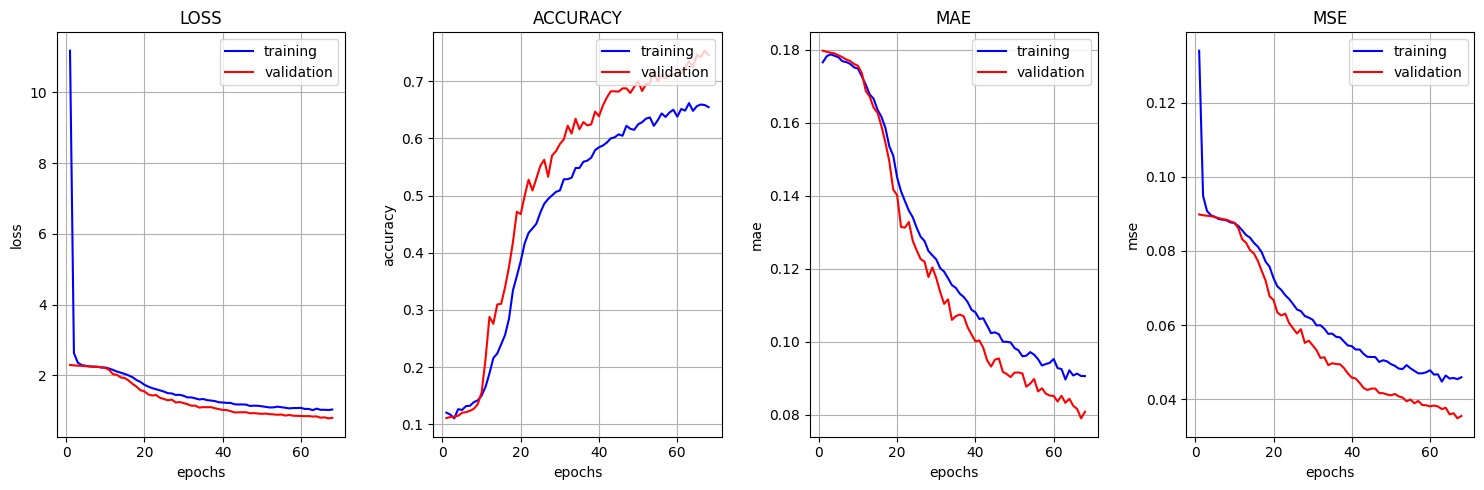

In [28]:
full_plot_model_metrics(history)

In [56]:
def plot_model_metrics(history):
    # разделяем данные из истории обучения на треноровочные и тестовые
    metrics = list(history.history.items())[:len(history.history.items())//2+1]
    val_metrics = list(history.history.items())[len(history.history.items())//2:]

    plt.figure(figsize=(30, 5))

    for i, metric, val_metric in zip(range(len(history.history.keys())), metrics, val_metrics):
        metric_mean = np.mean(metric[1][-3:])
        val_metric_mean = np.mean(val_metric[1][-3:])

        plt.subplot(1, len(history.history.items()), i+1)
        plt.plot(range(1, len(metric[1])+1), metric[1], c='blue', label='training')
        plt.ylim(0, metric_mean + val_metric_mean)
        plt.plot(range(1, len(val_metric[1])+1), val_metric[1], c='red', label='validation')
        plt.legend(loc='upper right')
        plt.title(metric[0].upper())
        plt.xlabel('epochs')
        plt.ylabel(metric[0])
        plt.tight_layout(h_pad=2, w_pad=2)
        plt.grid(True)

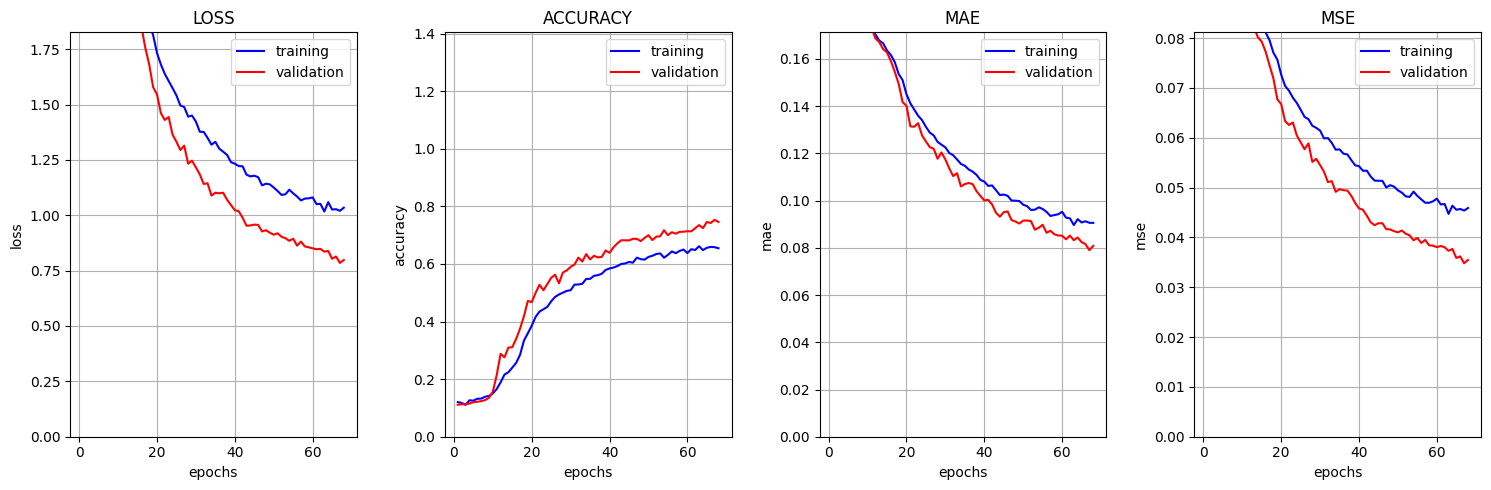

In [57]:
plot_model_metrics(history)

## Проверка работы модели на конкретном примере

`загрузка файла + обработка`

In [33]:
filepath=fr"C:\ML\DataBases\audios\fold1\7383-3-0-0.wav"
features =  feature_extractor(filepath)
features.shape

(40,)

In [34]:
ipd.Audio(filepath)

`изменяем размер данных`

In [35]:
features = features.reshape(1, -1)
features.shape

(1, 40)

`предсказание модели`  
возвращает вероятности того, что данный звук принадлежит определенному классу

In [36]:
predict = model.predict(features)
predict

1/1 [==============================] - 0s 49ms/step


array([[9.3583012e-08, 6.4783599e-05, 8.9955359e-04, 9.4685757e-01,
        3.1349570e-03, 8.7725844e-08, 4.7382511e-02, 9.1730261e-12,
        3.1333329e-04, 1.3470985e-03]], dtype=float32)

`выбор верного варианта, исходя из полученный вероятностей`

In [37]:
label = np.argmax(predict, axis=1)
res = le.inverse_transform(label)
res

array(['dog_bark'], dtype='<U16')